Exercise 1  EOQ

In [16]:
import math

d = 600  # kg/week
A = 26  # euro
c = 1.35  # euro/kg
holding_cost = 2.2 / 52  # euro/kg/week    # 1 year == 52 week

# Exercise 1. (a)

EOQ = math.sqrt(2 * d * A / holding_cost)
TRC = math.sqrt(2 * A * d * holding_cost)
T = EOQ / d

print("Optimal lot size: " + str(round(EOQ, 2)))
print("Optimal cost per period: " + str(round(TRC, 2)))
print("Cycle length: " + str(round(T, 2)))

# (b) Sensitivity analysis of EOQ

qt = 500
p = (qt - EOQ) / EOQ  # percentage deviation of order quantity
PCP = 50 * (p**2 / (1 + p))  # percentage cost penalty


def lot_cost(q):
    return d / q * A + 0.5 * holding_cost * q


# PCP = (lot_cost(qt)-TRC)/TRC *100
print("percentage deviation: " + str(round(p * 100, 2)) + "%")
print("percentage cost penalty: " + str(round(PCP)) + "%")


# (c) Power of two

t = 1
while lot_cost(2 * d * t) < lot_cost(d * t):
    t = t * 2
print("Optimal integer cycle: " + str(t))
p_error = round(100 * (lot_cost(d * t) / TRC - 1), 2)
print("Cost error: " + str(p_error) + "%")

Optimal lot size: 858.75
Optimal cost per period: 36.33
Cycle length: 1.43
percentage deviation: -41.78%
percentage cost penalty: 15%
Optimal integer cycle: 2
Cost error: 5.65%


Exercise 2 

Quantity discount models

In [17]:
# Exercise 2. (a) All-unit quantity discounts

d = 40 * 52  # unit/year
A = 25  # euro
r = 0.26  # euro/year #interest rate

bp = [0, 300, 500]  # break points of order quantity
cp = [10, 9.7, 9.5]  # perchasing prices

# step 1) Calculate EOQ for the discounted price:
t = len(cp) - 1  # start from the cheapest price
holding_cost = r * cp[t]
qt = math.sqrt(2 * A * d / holding_cost)

# step 2) Check if EOQ is feasible
if qt >= bp[t]:
    q_opt = qt
    c_opt = d / qt * A + 0.5 * holding_cost * qt + cp[t] * d
    print("EOQ at level " + str(t) + " feasible")
else:
    print("EOQ at level " + str(t) + " infeasible")

    # step 3) Calculate EOQ for the less favorable price
    while t >= 1 and qt < bp[t]:
        t -= 1
        holding_cost = r * cp[t]
        qt = math.sqrt(2 * A * d / holding_cost)
        cost_break = d / bp[t + 1] * A + 0.5 * r * cp[t + 1] * bp[t + 1] + cp[t + 1] * d
        cost_eoq = d / qt * A + 0.5 * holding_cost * qt + cp[t] * d
        # step 4) compare cost at the break point and at EOQ
        if cost_break < cost_eoq:
            q_opt = bp[t + 1]
            c_opt = cost_break
            print("Breakpoint " + str(t) + " preferred")
            break
        else:
            print("Lower EOQ at level " + str(t) + " preferred")
            q_opt = qt
            c_opt = cost_eoq
            if qt >= bp[t]:
                print("EOQ at level " + str(t) + " feasible")
            else:
                print("EOQ at level " + str(t) + " infeasible")

print("Optimal order: " + str(round(q_opt, 2)))
print("Optimal cost: " + str(round(c_opt, 2)))

EOQ at level 2 infeasible
Breakpoint 1 preferred
Optimal order: 500
Optimal cost: 20481.5


In [18]:
import numpy as np

# (b) incremental quantity discounts
d = 40 * 52  # unit/year
setup_cost = 25  # euro
r = 0.26  # euro/year

bp = [0, 300]
cp = [10, 9.7]

# step 1) Compute the sum of terms that are independent of Q in purchasing cost
R = np.zeros(len(bp))
for t in range(1, len(bp)):
    R[t] = cp[t - 1] * (bp[t] - bp[t - 1]) + R[t - 1]

print(R)
# step 2) Compute EOQ for all segments & Check the feasibility of EOQs
qt = np.zeros(len(bp))
flag_feasible = np.full(len(bp), False, dtype=bool)  # the indicator of feasibility
for t in range(len(bp)):
    qt[t] = math.sqrt(2 * (R[t] - cp[t] * bp[t] + setup_cost) * d / (r * cp[t]))
for t in range(len(bp) - 1):
    flag_feasible[t] = True if qt[t] >= bp[t] and qt[t] < bp[t + 1] else False
flag_feasible[-1] = True if qt[-1] >= bp[-1] else False

print("EOQ for all segments: " + str(qt))
print("EOQ is feasible: " + str(flag_feasible))


# step 3) Compute the total cost function for feasible EOQs
def lot_cost(q, h, c):
    return d / q * setup_cost + 0.5 * h * q + c * d


qt_f = list()
cost_qt_f = list()
for t in range(len(bp)):
    if flag_feasible[t]:
        q = qt[t]
        c = (R[t] + cp[t] * (q - bp[t])) / q
        holding_cost = c * r
        cost_q = lot_cost(q, holding_cost, c)
        qt_f.append(q)
        cost_qt_f.append(cost_q)
c_opt = min(cost_qt_f)
q_opt = qt_f[np.argmin(cost_qt_f)]
print("Optimal order: " + str(round(q_opt, 2)))
print("Optimal cost: " + str(round(c_opt, 2)))

[   0. 3000.]
EOQ for all segments: [200.         435.53498327]
EOQ is feasible: [ True  True]
Optimal order: 435.53
Optimal cost: 21286.12


Exercise 3 Newsvendor model

In [19]:
# Exercise 3. (a)
from scipy.stats import norm

mu = 2000
sigma = 250
p = 6
c = 3
g = 2.5

beta = (p - c) / (p - g)

qt = mu + sigma * norm.ppf(beta)  # inverse of cdf — percentiles

print("Newsvendor quantity: " + str(round(qt, 2)))

# (b) KPI calculations

z = (qt - mu) / sigma  # Standard Normal distribution
ELS = sigma * (norm.pdf(z) - z * (1 - norm.cdf(z)))
print("Expected lost sales: " + str(round(ELS, 2)))
ES = mu - ELS
print("Expected sales: " + str(round(ES, 2)))
ELO = qt - ES
print("Expected leftover: " + str(round(ELO, 2)))
EP = -c * qt + p * ES + g * ELO
print("Expected profit: " + str(round(EP, 2)))
alpha = beta
print("Service level Availability: " + str(round(alpha, 4)))
fill_rate = ES / mu
print("Service level Fill-rate: " + str(round(fill_rate, 4)))

Newsvendor quantity: 2266.89
Expected lost sales: 18.28
Expected sales: 1981.72
Expected leftover: 285.18
Expected profit: 5802.56
Service level Availability: 0.8571
Service level Fill-rate: 0.9909


Exercise 4

Effect of demand distribution on order quantity

Order quantity with uniformlly distributed demand: 7000
Order quantity with Poisson demand: 6052
Order quantity with Gamma demand: 6733


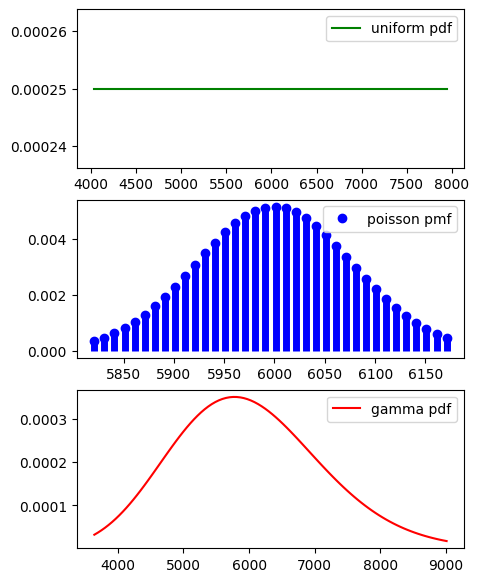

In [20]:
from scipy.stats import uniform, poisson, gamma
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(5, 7))

beta = 0.75  # critical ratio

# Exercise 4.
# (a) uniform distribution
_loc = 4000
_scale = 8000 - 4000

qt = uniform.ppf(beta, loc=_loc, scale=_scale)  # inverse of cdf — percentiles
print("Order quantity with uniformlly distributed demand: " + str(round(qt)))
# plot pdf
x = np.arange(uniform.ppf(0.01, _loc, _scale), uniform.ppf(0.99, _loc, _scale), 100)
axs[0].plot(x, uniform.pdf(x, _loc, _scale), "g-", label="uniform pdf")

# (b) poisson distribution
_lambda = 6000
qt = poisson.ppf(beta, _lambda)  # inverse of cdf — percentiles
print("Order quantity with Poisson demand: " + str(round(qt)))
# plot pmf
x = np.arange(poisson.ppf(0.01, _lambda), poisson.ppf(0.99, _lambda), 10)
axs[1].plot(x, poisson.pmf(x, _lambda), "bo", label="poisson pmf")
axs[1].vlines(x, 0, poisson.pmf(x, _lambda), colors="b", lw=5)

# (c) gamma distribution
_mean = 6000
_std = uniform.std(_loc, _scale)
_var = _std**2
# gamma parameters
_a = _mean**2 / _var
_beta = _var / _mean

qt = gamma.ppf(beta, _a, scale=_beta)  # inverse of cdf — percentiles
print("Order quantity with Gamma demand: " + str(round(qt)))
# plot pdf
x = np.linspace(gamma.ppf(0.01, _a, scale=_beta), gamma.ppf(0.99, _a, scale=_beta), 100)
axs[2].plot(x, gamma.pdf(x, _a, scale=_beta), "r-", label="gamma pdf")
for axs in axs.flat:
    axs.legend()
plt.show()

Exercise 5

Newsvendor quantity for required service level

In [21]:
p = 12 * 3
c = 20
g = 0
mu = 20
sigma = 8

# Exercise 5. (a) fill rate
from scipy.optimize import minimize_scalar

beta = 0.95  # fill rate


# minimize the difference between
def f(x):
    return abs((norm.pdf(x) - x * (1 - norm.cdf(x))) - (1 - beta) * mu / sigma)


z = minimize_scalar(f, method="golden")
print(f"{z}")
nv = np.ceil(mu + z.x * sigma)
print("Quantity with fill rate: " + str(int(nv)))

# (b) availability

alpha = 0.95
z = norm.ppf(alpha)  # Percent point function (inverse of cdf - percentiles)
nv = np.ceil(mu + z * sigma)
print("Quantity with non-stockout prob: " + str(int(nv)))

# (c)
z = (25 - mu) / sigma
prob = 1 - norm.cdf(z)
bonus = 100 * 48 * prob
print("Expected bounus per year: " + str(np.round(bonus, 2)))

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 4.5027301331934666e-10
       x: 0.7777186217248677
     nit: 39
    nfev: 44
Quantity with fill rate: 27
Quantity with non-stockout prob: 34
Expected bounus per year: 1276.73


Exercise 6

Multi-period lot-sizing problem

In [22]:
import numpy as np

# Input data
demands = np.array([550, 200, 400, 110, 430, 980, 400, 300, 200, 650])
setup_cost = 10000
holding_cost = 0.2 * 120  # euro/unit/period

num_periods = len(demands)

# Exercise 6. (a) Least unit cost heuristic
print("Least unit cost heuristic")


def cal_luc_criterion(t, z):
    holding_periods = [i for i in range(z - t + 1)]
    unit_cost = (
        setup_cost + holding_cost * np.sum(demands[t : z + 1] * holding_periods)
    ) / np.sum(demands[t : z + 1])
    return unit_cost


def make_setup_decision(func_cost):
    """
    Pass the LUC/SM function as a parameter 'func_cost'.
    Applies 'func_cost' to calculate the LUC/SM criterion.
    Returns the setup decision and lot-sizing decision.
    """
    flag_setup = np.full(
        num_periods, False, dtype=bool
    )  # the indicator of setup at period t
    lot_size = np.zeros(num_periods)
    t = 0
    while t < num_periods:
        z = t
        c_opt = func_cost(t, z)
        while c_opt > func_cost(t, z + 1):
            z += 1
            c_opt = func_cost(t, z)
            if z == num_periods - 1:
                break
        flag_setup[t] = True
        lot_size[t] = np.sum(demands[t : z + 1])
        t = z + 1
    return flag_setup, lot_size


def cal_total_cost(flag_setup, lot_size):
    """
    Calculates the total cost given a setup decision.
    """
    total_setup_cost = setup_cost * np.sum(flag_setup)
    # inventory holding cost
    inventory = np.zeros(num_periods)
    inventory[0] = lot_size[0] - demands[0]
    for t in range(1, num_periods):
        inventory[t] = inventory[t - 1] + lot_size[t] - demands[t]
    total_holding_cost = holding_cost * np.sum(inventory)
    total_cost = total_setup_cost + total_holding_cost
    return total_cost


flag_setup, lot_size = make_setup_decision(cal_luc_criterion)
total_cost = cal_total_cost(flag_setup, lot_size)
print("Setup decision: " + str(flag_setup))
print("Lot-sizing decision: " + str(lot_size))
print("Total costs " + str(total_cost))

# (b) Silver-Meal heuristic
print("\nSilver-Meal heuristic")


def cal_sm_criterion(t, z):
    holding_periods = [i for i in range(z - t + 1)]
    period_cost = (
        setup_cost + holding_cost * np.sum(demands[t : z + 1] * holding_periods)
    ) / (z - t + 1)
    return period_cost


flag_setup, lot_size = make_setup_decision(cal_sm_criterion)
total_cost = cal_total_cost(flag_setup, lot_size)
print("Setup decision: " + str(flag_setup))
print("Lot-sizing decision: " + str(lot_size))
print("Total costs " + str(total_cost))

Least unit cost heuristic
Setup decision: [ True  True False  True False  True  True False  True False]
Lot-sizing decision: [550. 600.   0. 540.   0. 980. 700.   0. 850.   0.]
Total costs 102720.0

Silver-Meal heuristic
Setup decision: [ True False  True False  True  True False  True False  True]
Lot-sizing decision: [ 750.    0.  510.    0.  430. 1380.    0.  500.    0.  650.]
Total costs 81840.0


In [23]:
# (c) Wagner-Whitin algorithm
num_periods = 6
# 2-d array consists of the total costs for all possible lot-sizing decisions
costs = np.full((num_periods, num_periods), np.inf)

costs[0, 0] = setup_cost  # Option 1: Order in the first period
for t in range(1, num_periods):
    costs[0, t] = costs[0, t - 1] + (t - 0) * holding_cost * demands[t]

costs[1, 1] = np.min(costs[:, 0]) + setup_cost  # Option 2: Order in the second period
for t in range(2, num_periods):
    costs[1, t] = costs[1, t - 1] + (t - 1) * holding_cost * demands[t]

costs[2, 2] = np.min(costs[:, 1]) + setup_cost  # Option 3: Order in the third period
for t in range(3, num_periods):
    costs[2, t] = costs[2, t - 1] + (t - 2) * holding_cost * demands[t]

costs[3, 3] = np.min(costs[:, 2]) + setup_cost  # Option 4: Order in the fourth period
for t in range(4, num_periods):
    costs[3, t] = costs[3, t - 1] + (t - 3) * holding_cost * demands[t]

costs[4, 4] = np.min(costs[:, 3]) + setup_cost  # Option 5: Order in the fifth period
for t in range(5, num_periods):
    costs[4, t] = costs[4, t - 1] + (t - 4) * holding_cost * demands[t]

costs[5, 5] = np.min(costs[:, 4]) + setup_cost  # Option 6: Order in the sixth period
for t in range(6, num_periods):
    costs[5, t] = costs[5, t - 1] + (t - 5) * holding_cost * demands[t]

print("Costs for all possible lot-sizing decisions: \n" + str(costs))


def get_setup_decision(costs):
    index_opt = np.argmin(costs, axis=0)
    setup_decision = np.full(
        num_periods, False, dtype=bool
    )  # the indicator of setup at period t
    setup_decision[0] = True
    for t in range(1, num_periods):
        if index_opt[t] == index_opt[t - 1]:
            setup_decision[t] = False
        else:
            setup_decision[t] = True
    return setup_decision


setup_decision = get_setup_decision(costs)
print("Setup decision: " + str(setup_decision))
print("Total costs " + str(np.min(costs[:, -1])))

Costs for all possible lot-sizing decisions: 
[[ 10000.  14800.  34000.  41920.  83200. 200800.]
 [    inf  20000.  29600.  34880.  65840. 159920.]
 [    inf     inf  24800.  27440.  48080. 118640.]
 [    inf     inf     inf  34800.  45120.  92160.]
 [    inf     inf     inf     inf  37440.  60960.]
 [    inf     inf     inf     inf     inf  47440.]]
Setup decision: [ True False  True False  True  True]
Total costs 47440.0


In [24]:
# (c) MILP model

import gurobipy as gp
from gurobipy import GRB, quicksum

model = gp.Model("Wagner-Whitin")

big_M = np.sum(demands)

# Create variables
lotsize = model.addVars(num_periods, vtype=GRB.INTEGER, name="lotsize")
setup = model.addVars(num_periods, vtype=GRB.BINARY, name="setup indicator")
inventories = model.addVars(num_periods, name="inventories")

# Set objective
model.setObjective(
    quicksum(
        setup[period] * setup_cost + holding_cost * inventories[period]
        for period in range(num_periods)
    ),
    GRB.MINIMIZE,
)

# Inventory balance constraints
model.addConstr(inventories[0] == lotsize[0] - demands[0])
model.addConstrs(
    inventories[period] == lotsize[period] - demands[period] + inventories[period - 1]
    for period in range(1, num_periods)
)
# Logic constraints
model.addConstrs(
    lotsize[period] <= big_M * setup[period] for period in range(num_periods)
)
# Run model
model.optimize()
# Print results
index_opt = {k: bool(v.X) for k, v in setup.items()}
lotsize_solution = {k: v.X for k, v in lotsize.items()}
print("\nSetup decision: " + str(index_opt))
print("Lot-sizing decision: " + str(lotsize_solution))
print("Objective: " + str(model.objVal))

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12 rows, 18 columns and 29 nonzeros
Model fingerprint: 0x6806f5ae
Variable types: 6 continuous, 12 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+03]
Found heuristic solution: objective 60000.000000
Presolve removed 3 rows and 4 columns
Presolve time: 0.00s
Presolved: 9 rows, 14 columns, 22 nonzeros
Variable types: 0 continuous, 14 integer (5 binary)

Root relaxation: objective 2.473211e+04, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 24732.1098    0    4 60000.0000 24732.1098  58.8%     -    

Exercise 7

In [25]:
# Exercise 7.

import gurobipy as gp
from gurobipy import GRB, quicksum

# Parameters
setup_cost = 180
holding_cost = 0.1 * 35
capacity = 25  # k

demands = np.array([12, 12, 1, 8, 15, 2, 7])
num_periods = len(demands)
big_M = np.sum(demands)

# Model
model = gp.Model("Wagner-Whitin")

# Create variables
lotsize = model.addVars(num_periods, vtype=GRB.INTEGER, name="lotsize")
setup = model.addVars(num_periods, vtype=GRB.BINARY, name="setup indicator")
inventories = model.addVars(num_periods, name="inventories")

# Set objective
model.setObjective(
    quicksum(
        setup[period] * setup_cost + holding_cost * inventories[period]
        for period in range(num_periods)
    ),
    GRB.MINIMIZE,
)

# Inventory balance constraints
model.addConstr(inventories[0] == lotsize[0] - demands[0])
model.addConstrs(
    inventories[period] == lotsize[period] - demands[period] + inventories[period - 1]
    for period in range(1, num_periods)
)
# Logic constraints
model.addConstrs(
    lotsize[period] <= big_M * setup[period] for period in range(num_periods)
)
# Capacity constraints
model.addConstrs(lotsize[period] <= capacity for period in range(num_periods))

# Run model
model.optimize()
# Print results
index_opt = {k: bool(v.X) for k, v in setup.items()}
lotsize_solution = {k: v.X for k, v in lotsize.items()}
print("\nSetup decision: " + str(index_opt))
print("Lot-sizing decision: " + str(lotsize_solution))
print("Objective: " + str(model.objVal))

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 21 columns and 41 nonzeros
Model fingerprint: 0xb3be1e87
Variable types: 7 continuous, 14 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 1260.0000000
Presolve removed 10 rows and 4 columns
Presolve time: 0.00s
Presolved: 11 rows, 17 columns, 27 nonzeros
Variable types: 0 continuous, 17 integer (6 binary)

Root relaxation: objective 5.154000e+02, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  515.40000    0    2 1260.00000  515.40000  59.1%     - 